In [1]:
%run ./resources/library.py

# Notebook 4 - Drawing an Isochrone Map with OSMnx for Soho District in London (Part 2)

## Learning Objectives

By the end of this notebook, you should be able to:

1. Describe the steps to identify points within isochrone polygons.
2. Load shapefiles into Geopandas dataframes and into Folium

## Counting points within isochrone polygons

In [ ]:
import geopandas as gpd
import pandas as pd

gpd.__version__, pd.__version__

In [2]:
trip_times = [1, 5, 10, 15]  # in minutes

BROAD_STREET_PUMP_COORDINATES = (51.513341, -0.136668)

### Set CRS to WGS84 lon/lat projection

In [3]:
wgs84_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
wgs84_crs = 'EPSG:4326'

### Load Cholera data

In [7]:
import geopandas as gpd
import pandas as pd
deaths_gdf = gpd.read_file('outputs/deaths.shp')
pumps_gdf = gpd.read_file('outputs/pumps.shp')
pumps_df = pd.read_pickle('outputs/pumps_df.pickle')

In [8]:
deaths_gdf

,FID,DEATHS,LON,LAT,geometry
0,0,3,-0.137930,51.513418,POINT (-0.13793 51.51342)
1,1,2,-0.137883,51.513361,POINT (-0.13788 51.51336)
2,2,1,-0.137853,51.513317,POINT (-0.13785 51.51332)
3,3,1,-0.137812,51.513262,POINT (-0.13781 51.51326)
4,4,4,-0.137767,51.513204,POINT (-0.13777 51.5132)
...,...,...,...,...,...
245,245,3,-0.137108,51.514526,POINT (-0.13711 51.51453)
246,246,2,-0.137065,51.514706,POINT (-0.13707 51.51471)
247,247,1,-0.138474,51.512311,POINT (-0.13847 51.51231)
248,248,1,-0.138123,51.511998,POINT (-0.13812 51.512)


In [9]:
pumps_gdf

,FID,LON,LAT,Street,PNODE,geometry
0,250,-0.136668,51.513341,Broadwick Street,12442012125,POINT (-0.13667 51.51334)
1,251,-0.139586,51.513876,Kingly Street,21665926,POINT (-0.13959 51.51388)
2,252,-0.139671,51.514906,Ramillies Place,4684520654,POINT (-0.13967 51.51491)
3,253,-0.131630,51.512354,Dean Street,12437452130,POINT (-0.13163 51.51235)
4,254,-0.133594,51.512139,Rupert Street,12505260549,POINT (-0.13359 51.51214)
5,255,-0.135919,51.511542,Bridle Lane,11331120233,POINT (-0.13592 51.51154)
6,256,-0.133962,51.510019,Regent Street,1663004187,POINT (-0.13396 51.51002)
7,257,-0.138199,51.511295,Warwick Street,25257692,POINT (-0.1382 51.51129)


In [10]:
pumps_df

,FID,LON,LAT,Street,PNODE
0,250,-0.136668,51.513341,Broadwick Street,12442012125
1,251,-0.139586,51.513876,Kingly Street,21665926
2,252,-0.139671,51.514906,Ramillies Place,4684520654
3,253,-0.131630,51.512354,Dean Street,12437452130
4,254,-0.133594,51.512139,Rupert Street,12505260549
5,255,-0.135919,51.511542,Bridle Lane,11331120233
6,256,-0.133962,51.510019,Regent Street,1663004187
7,257,-0.138199,51.511295,Warwick Street,25257692


### Load isochrone polygons from shapefiles to a dictionary of geodataframes

In [11]:
poly_gdf = {}
poly_gdf[15] = gpd.read_file('outputs/isopoly_15.shp')
poly_gdf[10] = gpd.read_file('outputs/isopoly_10.shp')
poly_gdf[5] = gpd.read_file('outputs/isopoly_5.shp')
poly_gdf[1] = gpd.read_file('outputs/isopoly_1.shp')

gdf_dict = {15:poly_gdf[15], 10:poly_gdf[10], 5:poly_gdf[5], 1:poly_gdf[1]}

polys_gdf = gpd.GeoDataFrame( pd.concat(gdf_dict, ignore_index=False) )
polys_gdf['points_in_isochrones'] = 0

polys_gdf1 = polys_gdf.reset_index()\
            .rename(columns={'level_0':'trip_time'})\
            .drop(columns=['level_1','FID']).sort_values(by=['trip_time'])
polys_gdf1

,trip_time,geometry,points_in_isochrones
3,1,"POLYGON ((-0.13694 51.51303, -0.13694 51.51303...",0
2,5,"POLYGON ((-0.13908 51.51129, -0.13911 51.51128...",0
1,10,"POLYGON ((-0.1438 51.51062, -0.1438 51.51062, ...",0
0,15,"POLYGON ((-0.14924 51.50993, -0.14925 51.50994...",0


In [12]:
import shapely.speedups
shapely.speedups.enable()

### Let's count the death location points in each isochrone polygon

We will subtract previous counts from subsequent isochrone polygons.

In [13]:
polys_gdf1.trip_time.astype(int)

prev_count = 0
for index, row in polys_gdf1.iterrows():
    #print(index,row)
    current_poly = polys_gdf1.at[index,'geometry']
    current_points = deaths_gdf['geometry']
    pip_mask = current_points.within(current_poly)
    points_in_isochrone = pip_mask.sum()
    polys_gdf1.at[index, 'points_in_isochrones'] = points_in_isochrone - prev_count
    prev_count = points_in_isochrone

In [14]:
polys_gdf1

,trip_time,geometry,points_in_isochrones
3,1,"POLYGON ((-0.13694 51.51303, -0.13694 51.51303...",30
2,5,"POLYGON ((-0.13908 51.51129, -0.13911 51.51128...",216
1,10,"POLYGON ((-0.1438 51.51062, -0.1438 51.51062, ...",4
0,15,"POLYGON ((-0.14924 51.50993, -0.14925 51.50994...",0


### Quick plots to visualize layout of isochrones and Cholera data

Text(0.5, 1.0, 'Broad Street Pump Isochrone Regions and Mortality and Other Pump Locations')

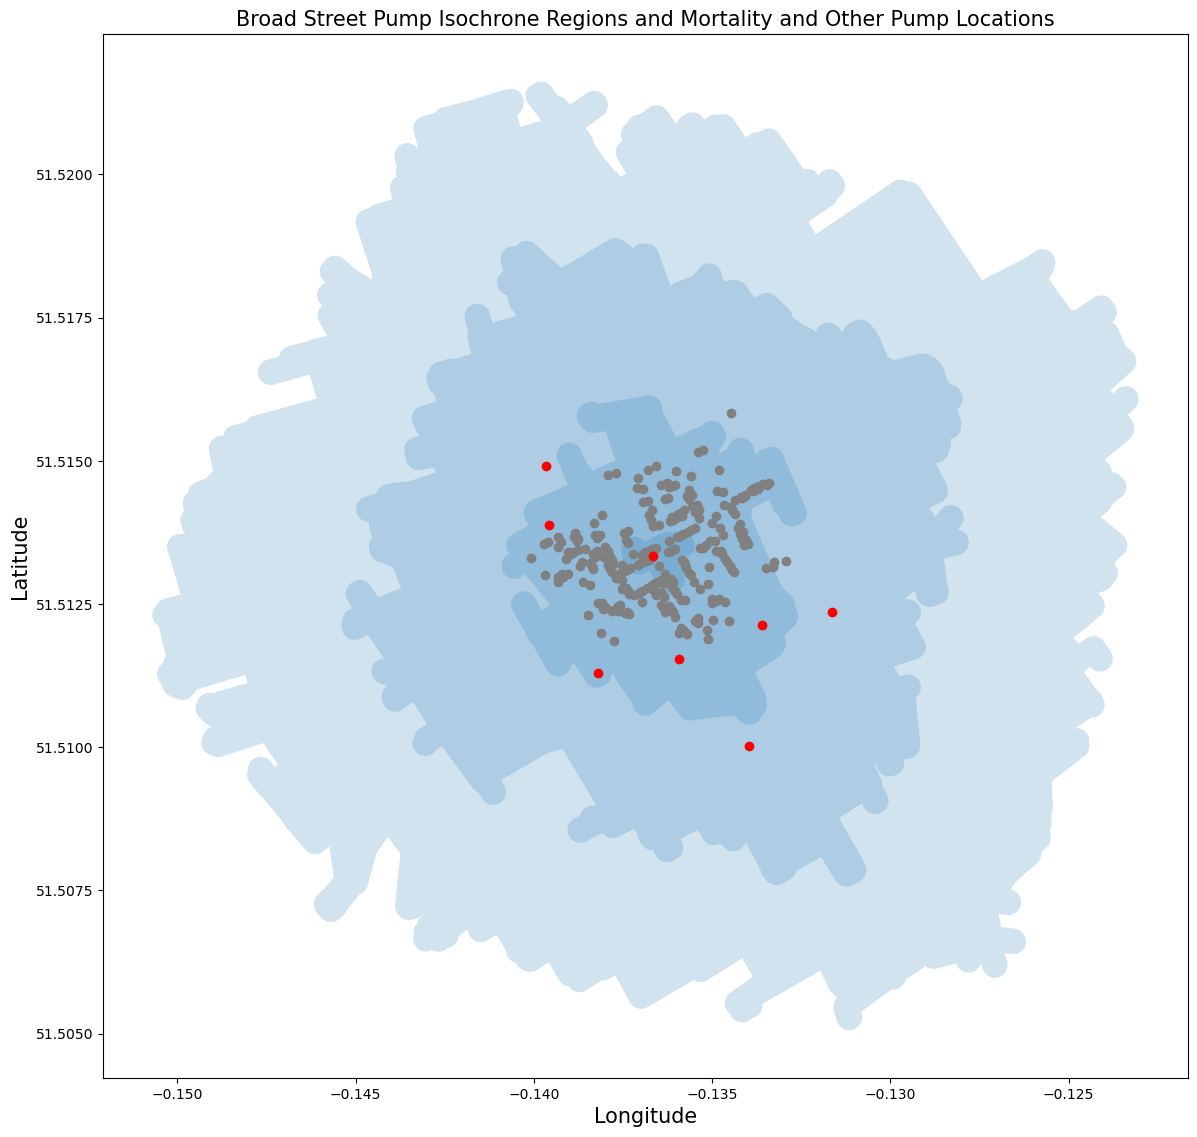

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,20))

# interval is [1, 5, 10, 15] minutes
for interval in trip_times:
    
    poly_gdf[interval].plot(ax=ax, alpha=0.2)

# plot cholera data
deaths_gdf.plot(ax=ax, color='gray')
pumps_gdf.plot(ax=ax, color='red')

ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
ax.set_title('Broad Street Pump Isochrone Regions and Mortality and Other Pump Locations', fontsize=15)

### Draw a bar chart of death location counts per isochrone polygon (region)

Text(0.5, 1.0, 'Death Locations in Isochrone Regions, Broad Street Pump')

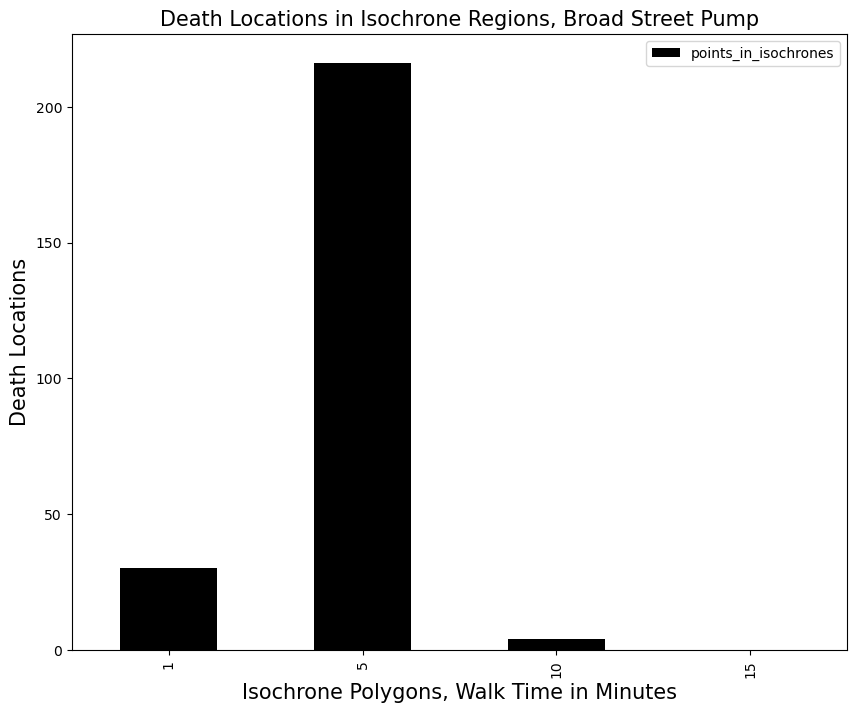

In [16]:
fig,ax = plt.subplots(figsize=(10,8))

pd.DataFrame(polys_gdf1[['trip_time','points_in_isochrones']])\
    .plot.bar(x='trip_time',color='black', ax=ax)

ax.set_xlabel('Isochrone Polygons, Walk Time in Minutes', fontsize=15)
ax.set_ylabel('Death Locations', fontsize=15)
ax.set_title('Death Locations in Isochrone Regions, Broad Street Pump', fontsize=15)

Which isochrone has the most mortality locations? What does that mean?

## Let's draw the Folium Map

In [17]:
import folium
from folium import plugins

folium.__version__

'0.12.1.post1'

In [18]:
map1 = folium.Map(location=BROAD_STREET_PUMP_COORDINATES, zoom_start=17, \
                 tiles='CARTODBPOSITRON')

deaths_df = pd.read_csv('resources/cholera_deaths.csv')

for index, row in polys_gdf1.iterrows():
    
    # adjust voronoi cell fill color based on points_in_voronoi value
    if row['points_in_isochrones'] > 200:
        color = 'red'
    elif row['points_in_isochrones'] <= 200 and row['points_in_isochrones'] > 40:
        color = 'orange'
    elif row['points_in_isochrones'] <= 40 and row['points_in_isochrones'] > 1:
        color = 'yellow'
    else:
        color = None
        
    # prepare for second "for" loop

    # create an empty list to hold lat,lon pairs 
    poly_list = []
    
    # extract x and y (lon and lat) from isochrone polygon (geometry column)
    x,y = row['geometry'].exterior.coords.xy
    
    # pair each x and y, like a zipper (zip)
    mapped = zip(x,y)
    
    # second "for" loop
    # create each polygon as lat, lon list (node the change in order)
    for lon,lat in mapped:
        poly_list.append([lat,lon])
    
    # add the folium Polygon
    folium.Polygon(poly_list,\
                    color='grey',\
                    weight=1,\
                    fill_opacity=0.1, \
                    fill_color=color).add_to(map1)    
    
locationlist = deaths_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_df[["DEATHS"]].values.tolist()

# Iterate through the rows of the cholera deaths data frame 
#    and add each cholera death circle marker to map1
for i in range(0, len(locationlist)):

    # Each marker will show point information and 
    #   number of deaths in that location.
    #
    # Compose popup text as HTML string
    popup_text = '<b>Location:</b> '+'('+str(locationlist[i][0])+\
                 ', '+str(locationlist[i][1])+')'+\
                 '<br/>'+\
                 '<b>Deaths:</b> '+ str(radiuslist[i][0])
    # Create a popup for each marker
    popup_death = folium.Popup(popup_text, max_width=200)
    
    # Add each circle marker with popup representing 
    #   a location with deaths to map1
    folium.CircleMarker(
                    location=locationlist[i], \
                    radius=radiuslist[i], \
                    popup=popup_death, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='red', \
                    fill_opacity=1).add_to(map1)
    
# Iterate through the rows of the pumps_df data frame 
#   and add each water pump to map1
for each in pumps_df.iterrows():
    
    # Each marker will show pump location information
    # Compose popup text
    popup_text = '<b>Location:</b> '+'('+str(each[1]['LAT'])+', '+str(each[1]['LON'])+')'+\
                 '<br/>'+\
                 '<b>Street Name:</b> '+each[1]['Street']
    # Create a popup for each marker
    popup_pump = folium.Popup(popup_text, max_width=200)

    # Add each circle marker with popup representing 
    #   a pump location to map1
    folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                    color='black', \
                    weight=1,\
                    fill_opacity=1, \
                    fill_color='blue', \
                    number_of_sides=4, \
                    popup=popup_pump, \
                    radius=10).add_to(map1)
    
# let's use the "Fullscreen" plugin
# add the button to the top right corner
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(map1)

map1

Don't forget to click on the Full Screen button to see the whole map display.

## References

1. Further Exploration #9: Isochrone Maps (Travel Time Maps). URL: http://datavizcatalogue.com/blog/isochrone-maps/
2. Boeing, G. Isochrone Maps with OSMnx + Python. URL: https://geoffboeing.com/2017/08/isochrone-maps-osmnx-python/
3. MapBox Isochrone Maps. URL: https://www.mapbox.com/bites/00156
4. https://en.wikipedia.org/wiki/Decimal_degrees


*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*